In [4]:
# Goals
# I have a dataset with 28126 rows and 183 features. The data is for a "mostly" e-commerce company located in Boston that sells
# furniture and home goods.

# For this company, my job/goal as a data scientist is to predict who will buy (classification) and how much (regression). 
# It is scored with ROC/AUC and RMSE

# CODE STRUCTURE
# BLOCK 1: IMPORTS
# BLOCK 2: STYLING
# BLOCK 3: DATA IMPORT
# BLOCK 4: DATA CLEANING - FUNCTION FOR CATEGORICAL DATA
# BLOCK 5: DATA ANALYSIS - PUREMEAN
# BLOCK 6: DATA CLEANING - REPLACING CATEGORICAL DATA
# BLOCK 7: DATA CLEANING - FEATURE REDUCTION AND ANALYSIS 
# BLOCK 8: DATA SPLITTING

In [5]:
# BLOCK 1: IMPORTS

# Python Library Imports 
import pandas as pd  # for Dataframes
import numpy as np  # for arrays
import matplotlib.pyplot as plt  # for plotting visuals

import xgboost as xgb  # boosted decision trees
import pandas_ml as pdml

import sklearn  # for machine learning
from sklearn import tree 
from sklearn import preprocessing

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import log_loss, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from IPython.display import Image

import pickle # persistant objects aka classifier after training

from collections import Counter
from sklearn.datasets import make_classification
import subprocess


In [6]:
# BLOCK 2: STYLING

# Styling
pd.set_option('notebook_repr_html', True)
pd.set_option('max_columns', 50)
# pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 40)
%matplotlib inline 
# pd.set_option('display.max_columns', None)

In [7]:
# BLOCK 3: DATA IMPORT

# Data Imports
csvfile = "df_training_scholarjet.csv"  # dataset to be used
dataframe_all = pd.read_csv(csvfile, index_col=0)  # read csvs file

dictfile = "Feature_Dictionary.xlsx"
feat_dict = pd.read_excel(dictfile)


# Data manipulation - Dropping some columns
dataframe_all.drop(["team", "accrole"], axis=1, inplace=True)  # drop unnecessary columns

df_shape = dataframe_all.shape  # save shape
print(df_shape)

# dataframe_all = dataframe_all.drop(["revenue_30"], axis=1, inplace=False)  # Do classificiation first ***

# dataframe_all = sklearn.utils.shuffle(dataframe_all) # shuffle

dataframe_all.index = range(df_shape[0])  # reindex dataframe
 
# print(dataframe_all.head())

(28126, 181)


In [8]:
# WIP - I want to be able to compare across multiple columns a pivot table? column x column x column combinations 

# dftest = dataframe_all[['roll_up','currentstatus', 'companytypegroup']]
# dftest['companytypegroup'].value_counts()
# pd.crosstab(dataframe_all['roll_up'], dataframe_all['currentstatus'])

In [9]:
# Clean Data
# 1. Change categorical data into numerical. Make sure to mainting data integrity for hierarchical categorical data. 
# probably use dummy vars for other categorical data.
# 2. Impute for missing numbers. I have a prediction that the more filled out the data entry is that it might mean that
# the customer is more engaged and likely to buy. Test after cleaning


In [10]:
# BLOCK 4: DATA CLEANING - CATEGORICAL DATA

# Data Cleaning
# Should I automate the categorical columns that have rankings?

# Find all columns with categorical aka object type data
categorical_data_list = []
for cat in range(df_shape[1]):
    if dataframe_all.dtypes[cat] == 'object':
        categorical_data_list.append(dataframe_all.columns[cat])

# Analyze the categorical data by finding Totals in each Unique categories
# how many are positives where customers bought
# total revenues to see if spending is different by group
def categoricalAnalysis(df, categList, convert, revenue):
    categ_list_len = len(categList)
    
    # lists to add to the returned dataframe
    categTotals = []
    categConvert = []
    categRevenues = []
    percentBuy = []
    
#     for all of the categorical columns
    for cat in range(categ_list_len):
        categTotalsd = {}
        categConvertd = {}
        categRevenuesd = {}
        percentBuyd = {}

        for index in range(len(df[categList[cat]].unique())):
            uniqueCat = df[categList[cat]].unique()[index]  # uniqueCat = iterates through actual unique category list

            categTotalsd[uniqueCat] = df[categList[cat]].value_counts()[uniqueCat]  # totals in cat
    
            #Convert for each cat
            tempDfcon = (df[convert]>0) & (df[categList[cat]] == uniqueCat)
            dfConvert = df[tempDfcon]
            categConvertd[uniqueCat] = dfConvert[convert].sum().round(2)            
        
            #Revenues for each cat
            tempDf = (df[revenue]>0) & (df[categList[cat]] == uniqueCat)
            dfUniqueAbove0 = df[tempDf]
            categRevenuesd[uniqueCat] = dfUniqueAbove0[revenue].sum().round(2)

            percentBuyd[uniqueCat] = categConvertd[uniqueCat] / categTotalsd[uniqueCat] 

            
#         append to lists     
        categTotals.append(categTotalsd)    
        categConvert.append(categConvertd)
        categRevenues.append(categRevenuesd)
        percentBuy.append(percentBuyd)
    d = {'CatColumns':categTotals, 'UniqueCat':categConvert, 'RevCat':categRevenues, 'PercentBuy':percentBuy}
    categorical_data_df = pd.DataFrame(d)
    return categorical_data_df

# call function to create new dataframe of all the raw info on categoricals
analysisDf = categoricalAnalysis(dataframe_all, categorical_data_list, "convert_30", "revenue_30")        
# print(analysisDf.values)
# print(categorical_data_list)
# analysisDf.values[9]                     

In [11]:
# BLOCK 5: DATA ANALYSIS - PUREMEAN

# Examine entire dataset to find percent of buyers to total
aboveAnalysis = dataframe_all['revenue_30'] > 0
aboveAnalysis = dataframe_all[aboveAnalysis]
print(len(aboveAnalysis), "out of a total of", len(dataframe_all), "bought" )
print("{:.2%}".format(len(aboveAnalysis) / len(dataframe_all)), "of all customers bought/converted")
print("The average a customer spend was:", "${:,.2f}".format(aboveAnalysis["revenue_30"].sum().round(2)))
print("The average a customer spend was:", "${:.2f}".format(aboveAnalysis["revenue_30"].sum().round(2)/len(aboveAnalysis)))
print("The average a population spends was:", "${:.2f}".format(aboveAnalysis["revenue_30"].sum().round(2)/len(dataframe_all)))
print("The total a population can spend:", "${:,.2f}".format(aboveAnalysis["revenue_30"].sum().round(2)/len(aboveAnalysis)*len(dataframe_all)))


# The mean score used for all those shitty small categories
pureMean = len(aboveAnalysis) / len(dataframe_all)


2928 out of a total of 28126 bought
10.41% of all customers bought/converted
The average a customer spend was: $2,110,546.84
The average a customer spend was: $720.82
The average a population spends was: $75.04
The total a population can spend: $20,273,647.69


In [20]:
# BLOCK 6: DATA CLEANING - REPLACING CATEGORICAL DATA

# Data Cleaning

#input mean scores into categories
#for all examples where the data has less than 1000 in the categories, input the pureMean

def replaceCategCols(df):
    replaceDf = pd.DataFrame(df, copy=True)
    for i, cat in enumerate(categorical_data_list):
        for j, unique in enumerate (replaceDf[cat].unique()):
    #         print(unique, analysisDf.values[i][0][unique] < 1000)
            if (analysisDf.values[i][0][unique]< 100):
                replaceDf[cat].replace(unique, pureMean,inplace=True)
            else:
                replaceDf[cat].replace(unique, analysisDf.values[i][3][unique],inplace=True)
    return replaceDf       

cleanedDf = pd.DataFrame(replaceCategCols(dataframe_all), copy = True)


In [13]:
# BLOCK 7: DATA CLEANING - FEATURE REDUCTION AND ANALYSIS 

#WIP
# print(pd.crosstab(cleanedDf['percentresolved'], cleanedDf['convert_30']))
pd.crosstab(dataframe_all['nps_count'], dataframe_all['convert_30'])





# Data Cleaning
# Feature Group - Order
# Testing my knowledge of what I already know questions
# if you recently bought something, how likely are you going to buy something again?
#     it would depend on if you were an individual consuemr or a b2b
#     1 requires 1 time use the other needs to restock
    
# how do you correlate domain knowledge into your model

# replaceDf[replaceDf.columns[12:37]].loc[:10]
# len(replaceDf.columns[12:37])

# replaceDf[replaceDf.columns[12]]
# print(pd.crosstab(replaceDf['numbamorder'], replaceDf['convert_30']))
# print(pd.crosstab(replaceDf['numselforder'], replaceDf['convert_30']))
# number vs sum
# bam vs self
# total vs average deviation?




convert_30,0,1
nps_count,,
1.0,1310,240
2.0,111,34
3.0,8,4
4.0,2,2


In [30]:
# BLOCK 8: DATA SPLITTING

cleanedDf.fillna(-99999, inplace=True)  # fill in NaNs with 0s
cleanedDf = sklearn.utils.shuffle(cleanedDf) # shuffle data

# cuid = pd.DataFrame(cleanedDf['cuid'], copy=True)
# cleanedDf.drop(['cuid'], axis=1, inplace=True)


# label data for models
yConv = pd.DataFrame(cleanedDf['convert_30'], copy=True)
yRegr = pd.DataFrame(cleanedDf['revenue_30'], copy=True)


# feature data for models
X = pd.DataFrame(cleanedDf, copy=True)
X.drop(['convert_30', 'revenue_30'], axis=1, inplace=True)

# splitting data
seed = 100
X_train, X_test, y_train, y_test = train_test_split(X, yConv, test_size=0.2, random_state=seed)
X_trainr, X_testr, y_trainr, y_testr = train_test_split(X, yRegr, test_size=0.2, random_state=seed)

# print(cleanedDf)

In [31]:
# BLOCK 9: MODEL - DECISION TREE (DT) CLASSIFICIER
# model
decisionTree = DecisionTreeClassifier(random_state=seed)

# train classifier
decisionTree.fit(X_train, y_train)

#predict output
DT_ypred = decisionTree.predict(X_test)
DT_ypredprob = decisionTree.predict_proba(X_test)

DT_accuracy = accuracy_score(y_test, DT_ypred)
DT_logloss = log_loss(y_test, DT_ypredprob)

print(" == Decision Tree ==")
print("Accuracy: {0:.2f}".format(DT_accuracy))
print("Log loss: {0:.2f}".format(DT_logloss))
print("Number of nodes created: {}".format(decisionTree.tree_.node_count))



 == Decision Tree ==
Accuracy: 0.84
Log loss: 5.65
Number of nodes created: 3603


In [ ]:
# dt_viz_file = 'dt.dot'
# dt_png_file = 'dt.png'

# #create visualizations
# export_graphviz(decisionTree, out_file = dt_viz_file)

# #conver to png
# command = ["dot", "-Tpng", dt_viz_file, "-o", dt_png_file]
# subprocess.check_call(command, shell=True)

# Image(filename=dt_png_file)

In [32]:
# BLOCK 9: MODEL - DECISION TREE (DT) REGRESSOR
decisionTreer = DecisionTreeRegressor(random_state=seed)

# train classifier
decisionTreer.fit(X_trainr, y_trainr)

#predict output
DT_ypredr = decisionTreer.predict(X_testr)
# DT_ypredprobr = decisionTreer.predict_proba(X_testr)

# DT_accuracyr = accuracy_score(y_testr, DT_ypredr)
# DT_loglossr = log_loss(y_testr, DT_ypredprobr)

# print(" == Decision Tree ==")
# print("Accuracy: {0:.2f}".format(DT_accuracyr))
# print("Log loss: {0:.2f}".format(DT_loglossr))
# print("Number of nodes created: {}".format(decisionTreer.tree_.node_count))
# print(DT_ypredr[100], y_testr)

# for i, ind in enumerate(DT_ypredr[:100]):
#     print(DT_ypredr[i], "     ",y_testr.iloc[i].values[0] )


In [33]:
# BLOCK 10: MODEL - ADA CLASSIFIER

# AdaBoost
adaboost = AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=1),
    algorithm='SAMME',
    n_estimators = 50,
    random_state = seed)

#train classifier
adaboost.fit(X_train, y_train.values.ravel())

#calculate predictions
adaboost_y_pred = adaboost.predict(X_test)
adaboost_y_pred_prob = adaboost.predict_proba(X_test)

#evaluate
adaboost_accuracy = accuracy_score(y_test, adaboost_y_pred)
adaboost_logloss = log_loss(y_test, adaboost_y_pred_prob)

print("==AdaBoost ==")
print("Accuracy: {0:.2f}".format(adaboost_accuracy))
print("Log loss: {0:.2f}".format(adaboost_logloss))
print()


==AdaBoost ==
Accuracy: 0.90
Log loss: 0.60



[0 0 0 0 0]
[0 0 0 0 0]
[[0.57930304 0.42069696]
 [0.57641377 0.42358623]
 [0.55181673 0.44818327]
 [0.57616878 0.42383122]
 [0.57641377 0.42358623]]


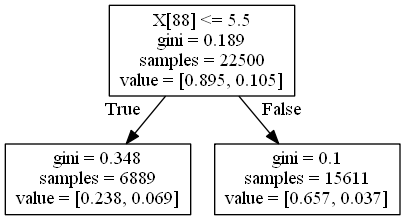

In [34]:
print_y_test = np.array(y_test[:5].values.ravel())

print(print_y_test)
print(adaboost_y_pred[:5])
print(adaboost_y_pred_prob[:5])


ada_t1 = adaboost.estimators_[0]
ada_t1_viz_file = 'images/ada-t1.dot'
ada_t1_png_file = 'images/ada-t1.png'

#create visualizations
export_graphviz(ada_t1, out_file=ada_t1_viz_file)

#convert to png
command = ["dot", "-Tpng", ada_t1_viz_file, "-o", ada_t1_png_file]
subprocess.check_call(command, shell=True)

Image(filename=ada_t1_png_file)
    
    

In [36]:
X.columns[90]
print("Error: {0:.2f}".format(adaboost.estimator_errors_[0]))
print("Tree Importance: {0:.2f}".format(adaboost.estimator_weights_[0]))


Error: 0.11
Tree Importance: 2.14


In [37]:
gbc = GradientBoostingClassifier(max_depth = 1,
                                 n_estimators = 100,
                                 warm_start = True,
                                 random_state = seed)
gbc.fit(X_train, y_train.values.ravel())

# make predictions
gbc_y_pred = gbc.predict(X_test)
gbc_y_pred_prob = gbc.predict_proba(X_test)

#calculate log loss
gbc_accuracy = accuracy_score(y_test, gbc_y_pred)
gbc_logloss = log_loss(y_test, gbc_y_pred_prob)

print("== Gradient Boosting ==")
print("Accuracy: {0:.2f}".format(gbc_accuracy))
print("Log loss: {0:.2f}".format(gbc_logloss))

== Gradient Boosting ==
Accuracy: 0.90
Log loss: 0.26


In [38]:
print_y_test = np.array(y_test[:5].values.ravel())

print(print_y_test)
print(gbc_y_pred[:5])
print(gbc_y_pred_prob[:5])

[0 0 0 0 0]
[0 0 0 0 0]
[[0.97235716 0.02764284]
 [0.96449813 0.03550187]
 [0.83068374 0.16931626]
 [0.95829348 0.04170652]
 [0.96316878 0.03683122]]


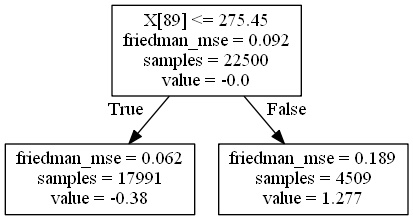

In [39]:
gbc_t1 = gbc.estimators_[2][0]
gbc_t1_viz_file = 'images/gbc-t1.dot'
gbc_t1_png_file = 'images/gbc-t1.png'

#create visualizations
export_graphviz(gbc_t1, out_file=gbc_t1_viz_file)

#convert to png
command = ["dot", "-Tpng", gbc_t1_viz_file, "-o", gbc_t1_png_file]
subprocess.check_call(command, shell=True)

Image(filename=gbc_t1_png_file)

In [40]:





data = X_train
label = y_train
dtrain = xgb.DMatrix(data=data, label=label)

dataTest = X_test
labelTest = y_test
dtest = xgb.DMatrix(dataTest, label=labelTest)


# len(dtrain.get_label())

param = {'max_depth': 2,
         'eta': 1,
         'silent': 1,
         'objective': 'binary:logistic',
         'nthread': 4,
         'eval_metric': 'auc'}

evallist = [(dtest, 'eval'), (dtrain, 'train')]


num_round = 20
bst = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-auc:0.749049	train-auc:0.742245
[1]	eval-auc:0.763963	train-auc:0.76095
[2]	eval-auc:0.785309	train-auc:0.788013
[3]	eval-auc:0.792387	train-auc:0.801321
[4]	eval-auc:0.800573	train-auc:0.807838
[5]	eval-auc:0.805079	train-auc:0.80987
[6]	eval-auc:0.803602	train-auc:0.812981
[7]	eval-auc:0.802393	train-auc:0.814215
[8]	eval-auc:0.803485	train-auc:0.815888
[9]	eval-auc:0.805099	train-auc:0.817912
[10]	eval-auc:0.806944	train-auc:0.819755
[11]	eval-auc:0.807456	train-auc:0.820934
[12]	eval-auc:0.80601	train-auc:0.82152
[13]	eval-auc:0.80697	train-auc:0.82261
[14]	eval-auc:0.806771	train-auc:0.823107
[15]	eval-auc:0.806597	train-auc:0.823581
[16]	eval-auc:0.807792	train-auc:0.824686
[17]	eval-auc:0.808288	train-auc:0.825387
[18]	eval-auc:0.808263	train-auc:0.825975
[19]	eval-auc:0.809934	train-auc:0.826825


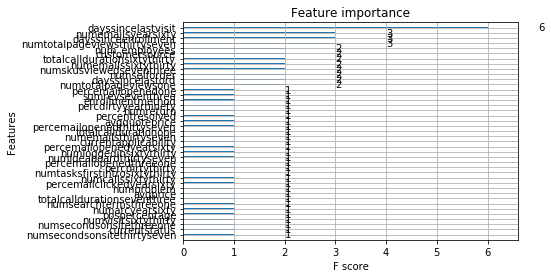

In [41]:
ypred = bst.predict(dtest)
xgb.plot_importance(bst)